# Data Analysis for FD001

In [153]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.nonparametric.smoothers_lowess import lowess
import pymannkendall as mk

## Data Preprocessing

In [154]:
train_data_df = pd.read_csv('../../TED/CMAPSSData/train_FD001.txt', sep=' ', header = None)
test_data_df = pd.read_csv('../../TED/CMAPSSData/test_FD001.txt', sep=' ', header = None)
test_labels_at_break_df = pd.read_csv('../../TED/CMAPSSData/RUL_FD001.txt', sep=' ', header = None)

train_data_df.drop(train_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_data_df.drop(test_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_labels_at_break_df.drop(test_labels_at_break_df.columns[[-1]], axis=1, inplace=True)

### Extracting labels and organising the data

In [155]:
column_names = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']

train_data_df.columns = column_names
max_cycles_train_df = train_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

train_data_df = pd.merge(train_data_df, max_cycles_train_df, how='inner', on='ID')
train_data_df['RUL'] = train_data_df['MaxCycleID'] - train_data_df['Cycle']
train_data_df.drop(columns=['MaxCycleID'], inplace=True)

test_data_df.columns = column_names
max_cycles_test_df = test_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

test_labels_at_break_df.columns = ['RUL']
test_labels_at_break_df['ID'] = max_cycles_test_df['ID']
test_labels_at_break_df['RUL'] = test_labels_at_break_df['RUL'] + max_cycles_test_df['MaxCycleID']

test_data_df = pd.merge(test_data_df, test_labels_at_break_df, how='inner', on='ID')
test_data_df['RUL'] = test_data_df['RUL'] - test_data_df['Cycle']

In [156]:
train_labels_df = train_data_df['RUL']
test_labels_df = test_data_df['RUL']
train_labels_at_break_df = train_data_df.groupby('ID').last().reset_index()['RUL']

### Divide by engine

In [157]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

### Graphs: Data before analysed

In [158]:
sensor_names = []
for i in range(3):
    sensor_names.append('OpSet' + str(i+1))
for i in range(21):
    sensor_names.append('SensorMeasure' + str(i+1))

In [159]:
def divide_by_engine(df_groupby):

    groupby_arr = []
    for i in range(len(df_groupby)):
        groupby_arr.append(df_groupby.get_group(i+1))

    for i in range(len(df_groupby)):
        groupby_arr[i] = groupby_arr[i].to_numpy()

    return groupby_arr

In [160]:
def plot_by_engine(train_gb, rows, names, filename):

    train_groupby_arr = divide_by_engine(train_gb)

    fig, axs = plt.subplots(rows, 4)
    flat_axs = axs.flatten()
    for sensor in range(len(names)):
        flat_axs[sensor].set_title(names[sensor])
        for engine in range(len(train_groupby_arr)):
            flat_axs[sensor].plot(train_groupby_arr[engine][:, 1], train_groupby_arr[engine][:, sensor + 2])

    plt.setp(axs[-1, :], xlabel='Cycles')
    plt.setp(axs[:, 0], ylabel='Sensor readings')
    fig.set_size_inches(20, 30) 
    plt.savefig(filename)
    plt.show()

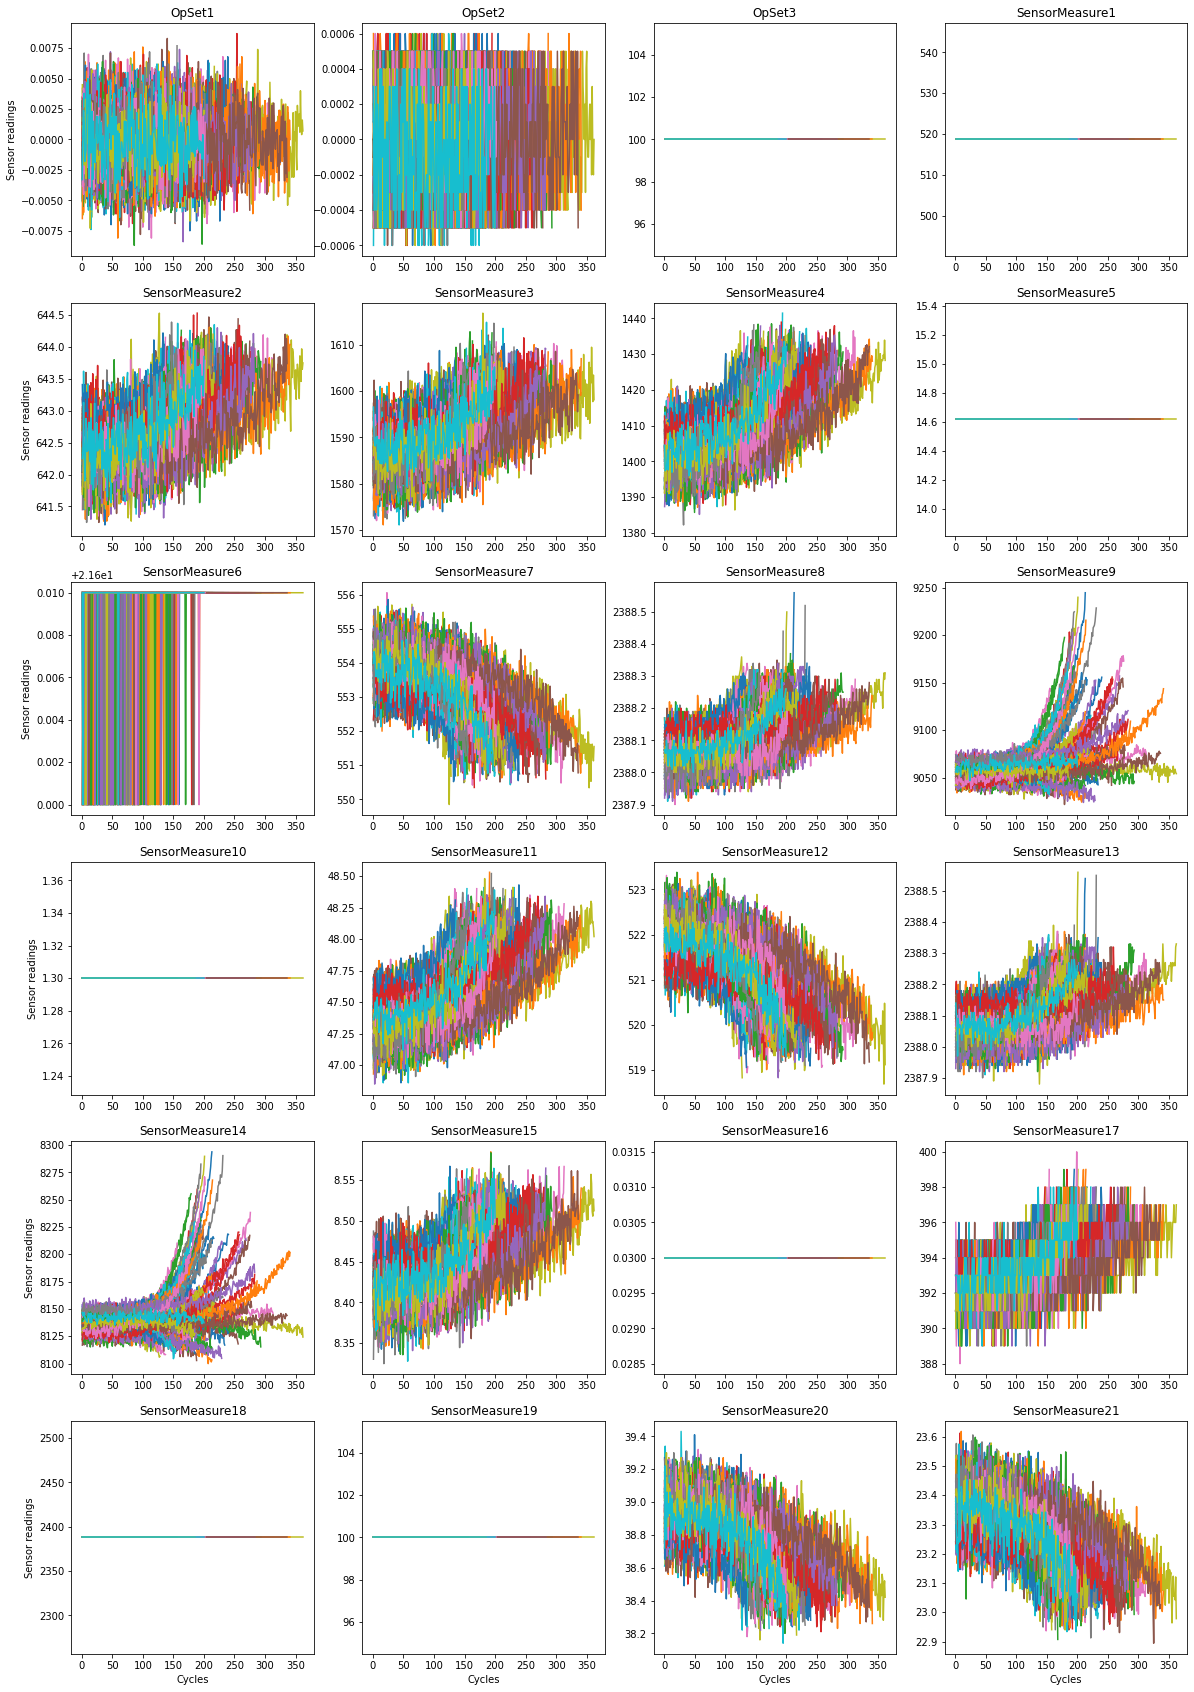

In [161]:
plot_by_engine(train_groupby, 6, sensor_names, 'fd001-sensors_unprocessed.jpg')

From the graph, we can see which sensors will have a greater impact on the performance of the regressor, and which are irrelevant for this task. I decided to take Sensors: 1, 5, 6, 10, 16, 18, 19

### Taking away all non-important sensors

In [162]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    # if i not in [1, 5, 6, 10, 16, 18, 19]:
    sensors_used.append("SensorMeasure" + str(i))

In [163]:
train_data_df = train_data_df[sensors_used]
train_grouppby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

In [164]:
train_data_df

ID  Cycle  SensorMeasure1  SensorMeasure2  SensorMeasure3  \
0        1      1          518.67          641.82         1589.70   
1        1      2          518.67          642.15         1591.82   
2        1      3          518.67          642.35         1587.99   
3        1      4          518.67          642.35         1582.79   
4        1      5          518.67          642.37         1582.85   
...    ...    ...             ...             ...             ...   
20626  100    196          518.67          643.49         1597.98   
20627  100    197          518.67          643.54         1604.50   
20628  100    198          518.67          643.42         1602.46   
20629  100    199          518.67          643.23         1605.26   
20630  100    200          518.67          643.85         1600.38   

       SensorMeasure4  SensorMeasure5  SensorMeasure6  SensorMeasure7  \
0             1400.60           14.62           21.61          554.36   
1             1403.14           14.62           21.61          553.75   
2             1404.20           14.62           21.61          554.26   
3             1401.87           14.62           21.61          554.45   
4             1406.22           14.62           21.61          554.00   
...               ...             ...             ...             ...   
20626         1428.63           14.62           21.61          551.43   
20627         1433.58           14.62           21.61          550.86   
20628         1428.18           14.62           21.61          550.94   
20629         1426.53           14.62           21.61          550.68   
20630         1432.14           14.62           21.61          550.79   

       SensorMeasure8  ...  SensorMeasure12  SensorMeasure13  SensorMeasure14  \
0             2388.06  ...           521.66          2388.02          8138.62   
1             2388.04  ...           522.28          2388.07          8131.49   
2             2388.08  ...           522.42          2388.03          8133.23   
3             2388.11  ...           522.86          2388.08          8133.83   
4             2388.06  ...           522.19          2388.04          8133.80   
...               ...  ...              ...              ...              ...   
20626         2388.19  ...           519.49          2388.26          8137.60   
20627         2388.23  ...           519.68          2388.22          8136.50   
20628         2388.24  ...           520.01          2388.24          8141.05   
20629         2388.25  ...           519.67          2388.23          8139.29   
20630         2388.26  ...           519.30          2388.26          8137.33   

       SensorMeasure15  SensorMeasure16  SensorMeasure17  SensorMeasure18  \
0               8.4195             0.03              392             2388   
1               8.4318             0.03              392             2388   
2               8.4178             0.03              390             2388   
3               8.3682             0.03              392             2388   
4               8.4294             0.03              393             2388   
...                ...              ...              ...              ...   
20626           8.4956             0.03              397             2388   
20627           8.5139             0.03              395             2388   
20628           8.5646             0.03              398             2388   
20629           8.5389             0.03              395             2388   
20630           8.5036             0.03              396             2388   

       SensorMeasure19  SensorMeasure20  SensorMeasure21  
0                100.0            39.06          23.4190  
1                100.0            39.00          23.4236  
2                100.0            38.95          23.3442  
3                100.0            38.88          23.3739  
4                100.0            38.90          23.4044  
...                ...              ...           

### Principal Component Analysis

In [165]:
train_data_df.shape
ms_used = sensors_used[2:]

In [166]:
sc = StandardScaler()
scaled_values = sc.fit_transform(train_data_df.values[:, 2:])

pca = PCA(n_components = 0.99)
pca_values = pca.fit_transform(scaled_values)

Number of components: 14


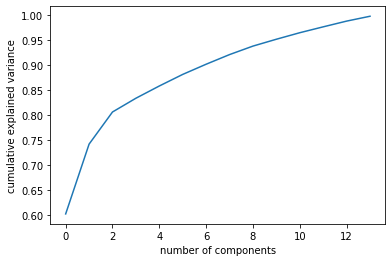

In [167]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print("Number of components: " + str(pca.n_components_))

In [168]:
pd.DataFrame(pca.components_, columns = ms_used)

SensorMeasure1  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0              0.0        0.272745        0.259608        0.300590   
1             -0.0        0.018285        0.077362        0.010472   
2              0.0        0.021938        0.030742        0.017800   
3             -0.0       -0.189851        0.933974       -0.035292   
4             -0.0       -0.555207        0.080600       -0.031263   
5              0.0        0.736235        0.166627       -0.093018   
6             -0.0       -0.075695       -0.047675       -0.016155   
7             -0.0       -0.091757       -0.055458        0.067576   
8              0.0       -0.142491       -0.114110        0.313850   
9              0.0       -0.040399       -0.007891        0.347375   
10            -0.0       -0.010248       -0.003872       -0.714399   
11             0.0        0.033634        0.019558        0.327389   
12            -0.0       -0.023168       -0.015080       -0.222047   
13            -0.0        0.024304        0.006939        0.086074   

    SensorMeasure5  SensorMeasure6  SensorMeasure7  SensorMeasure8  \
0     4.336809e-19        0.062346       -0.297857        0.281276   
1    -5.551115e-17       -0.047848        0.051601       -0.243179   
2     2.220446e-16       -0.996619       -0.016378        0.031899   
3     1.110223e-16        0.017198        0.029238       -0.020972   
4     8.326673e-17       -0.001799       -0.010373        0.003199   
5    -1.387779e-16        0.009549        0.092436       -0.043962   
6    -4.597017e-17        0.004508       -0.013463        0.014678   
7     7.632783e-17       -0.010006       -0.059318        0.067024   
8    -8.847090e-17       -0.002505       -0.355614        0.211860   
9     2.359224e-16        0.002523        0.844966        0.250297   
10    9.714451e-17       -0.001432       -0.018534        0.447361   
11    2.498002e-16        0.003562       -0.162211        0.533432   
12   -1.110223e-16        0.004314        0.148230        0.497176   
13    3.330669e-16        0.004239       -0.077733        0.118141   

    SensorMeasure9  SensorMeasure10  ...  SensorMeasure12  SensorMeasure13  \
0         0.105348     2.019484e-28  ...        -0.303857         0.280940   
1         0.643369    -0.000000e+00  ...         0.062021        -0.245119   
2        -0.026288     0.000000e+00  ...        -0.021794         0.024193   
3        -0.046016     2.775558e-17  ...         0.021280        -0.022755   
4        -0.041997    -0.000000e+00  ...         0.026332         0.004658   
5        -0.056359     4.163336e-17  ...         0.060155        -0.039237   
6         0.016677    -4.857226e-17  ...        -0.021753         0.022768   
7         0.039721    -0.000000e+00  ...        -0.052536         0.047158   
8         0.144672     1.734723e-18  ...        -0.193347         0.216009   
9         0.073854     0.000000e+00  ...        -0.030132         0.294170   
10        0.170575    -0.000000e+00  ...         0.157295         0.452142   
11        0.011072     0.000000e+00  ...         0.674628        -0.273014   
12       -0.006092    -5.551115e-17  ...        -0.450843        -0.662353   
13        0.043313     0.000000e+00  ...        -0.416788         0.066973   

    SensorMeasure14  SensorMeasure15  SensorMeasure16  SensorMeasure17  \
0          0.065960         0.286543     3.081488e-32         0.268728   
1          0.666277         0.021569    -1.232595e-32         0.078088   
2         -0.029339         0.007200     0.000000e+00         0.012381   
3         -0.041060        -0.076793     3.388132e-21        -0.251021   
4         -0.041630        -0.032561    -0.000000e+00         0.813331   
5         -0.049468        -0.182023     0.000000e+00         0.395596   
6          0.009162        -0.110215    -0.000000e+00        -0.068494   
7          0.037119         0.746489    -0.000000e+00        -0.117791   
8          0.134597        -0.550237     0.000000e+00        -0.1

In [169]:
n_pcs = pca.n_components_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = ms_used
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

['SensorMeasure11', 'SensorMeasure14', 'SensorMeasure6', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure2', 'SensorMeasure21', 'SensorMeasure15', 'SensorMeasure15', 'SensorMeasure7', 'SensorMeasure4', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure11']


In [170]:
fig = px.scatter_3d(pca_values, x=0, y=1, z=2, color=train_data_df['ID'])
fig.show()
fig.write_html("fd001-PCA-3d_plot.html")

Sensors 2, 3, 4, 6, 7, 11, 12, 13, 14, 15, 17, 21 contribute the most to each of the components of the PCA, so they could have value towards the performance of the algorithm.

### Feature Selection using Mann-Kendall method

<function matplotlib.pyplot.show(close=None, block=None)>

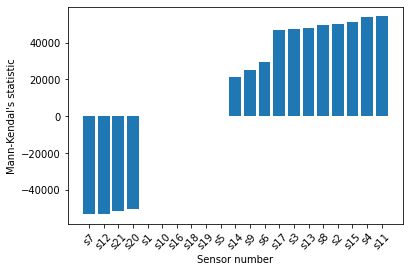

In [171]:
# PyMannKendall test: Code by Zhan Liang, Chan - https://github.com/cchanzl/survival-analysis-nasa/blob/main/nasa_eda.ipynb
avg_cycle = []
for i in range(1, 101):
    df_engine = train_data_df[train_data_df['ID'] == i]
    max_cycle = df_engine.loc[df_engine['Cycle'].idxmax()]
    avg_cycle.append(max_cycle["Cycle"].astype(int))

no_columns = 21
up_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
lo_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
for col in range(0, no_columns):
    sensor = 'SensorMeasure'
    sensor = sensor + str(col+1)
    for row in range(0, max(avg_cycle)):
        df_train_sens = train_data_df[train_data_df['Cycle'] == row+1]
        
        # find max and min value of a sensor for each cycle
        max_value = df_train_sens.loc[df_train_sens[sensor].idxmax()]
        min_value = df_train_sens.loc[df_train_sens[sensor].idxmin()]
        
        # store max and min value
        up_sensor_values[row, col] = max_value[sensor]
        lo_sensor_values[row, col] = min_value[sensor]
mean_trend = (up_sensor_values + lo_sensor_values)/2

mono = []
def MannKendall(sensor_number, mean_trend, p_value=False):
    sensor_number -= 1
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test([row[sensor_number] for row in mean_trend], alpha=0.05)
    if p_value:
        print("{:e}".format(var_s))
    return s

# make x label for graphing
sensor_header = []
for i in range(0, 21):
    name = "s"
    name = name + str(i+1)
    sensor_header.append(name)

# retrieve y axis reading
for i in range(1, no_columns+1):
    mono.append(MannKendall(i, mean_trend))

y,x = zip(*sorted(zip(mono,sensor_header)))
plt.bar(x, y)
plt.xlabel("Sensor number")
plt.ylabel("Mann-Kendal's statistic")
plt.xticks(rotation=45)
plt.show

According to the PyMannKendall test, the most useful sensors would be 2, 3, 4, 7, 8, 11, 12, 13, 15, 17, 20, 21. I will follow Zhan's decision on feature selection.

In [172]:
train_data_df.to_csv('./fd001-raw_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df[train_data_df.columns].to_csv('./fd001-raw_test.csv', sep=' ', columns=train_data_df.columns, index=False)

In [173]:
train_labels_df.to_csv('./fd001-training_labels.csv', sep=' ', columns=['RUL'], index=False)
test_labels_df.to_csv('./fd001-testing_labels.csv', sep=' ', columns=['RUL'], index=False)
train_labels_at_break_df.to_csv('./fd001-testing_labels_at_break.csv', sep=' ', columns=['RUL'], index=False)

In [174]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    if i not in [1, 5, 6, 9, 10, 14, 16, 18, 19]:
        sensors_used.append("SensorMeasure" + str(i))
ms_used = sensors_used[2:]

### Scaling and Normalising Data

In [175]:
train_data_df = train_data_df[sensors_used]
test_data_df = test_data_df[sensors_used]

In [176]:
sc = StandardScaler()
for sensor in ms_used:
    train_data_df.loc[:,sensor] = sc.fit_transform(train_data_df[sensor].values.reshape(-1, 1))
    test_data_df.loc[:,sensor] = sc.fit_transform(test_data_df[sensor].values.reshape(-1, 1))

/var/folders/4z/dx20wtl948x13fj468s2l3280000gn/T/ipykernel_19854/3213288972.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4z/dx20wtl948x13fj468s2l3280000gn/T/ipykernel_19854/3213288972.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4z/dx20wtl948x13fj468s2l3280000gn/T/ipykernel_19854/3213288972.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [177]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1       -1.721725       -0.134255       -0.925936   
1        1      2       -1.061780        0.211528       -0.643726   
2        1      3       -0.661813       -0.413166       -0.525953   
3        1      4       -0.661813       -1.261314       -0.784831   
4        1      5       -0.621816       -1.251528       -0.301518   
...    ...    ...             ...             ...             ...   
20626  100    196        1.618000        1.216258        2.188375   
20627  100    197        1.717992        2.279706        2.738351   
20628  100    198        1.478011        1.946971        2.138377   
20629  100    199        1.098043        2.403666        1.955051   
20630  100    200        2.337940        1.607712        2.578358   

       SensorMeasure7  SensorMeasure8  SensorMeasure11  SensorMeasure12  \
0            1.121141       -0.516338        -0.266467         0.334262   
1            0.431930       -0.798093        -0.191583         1.174899   
2            1.008155       -0.234584        -1.015303         1.364721   
3            1.222827        0.188048        -1.539489         1.961302   
4            0.714393       -0.516338        -0.977861         1.052871   
...               ...             ...              ...              ...   
20626       -2.189329        1.315066         1.980044        -2.607969   
20627       -2.833345        1.878576         1.867718        -2.350355   
20628       -2.742957        2.019453         2.054927        -1.902919   
20629       -3.036719        2.160330         3.178182        -2.363913   
20630       -2.912435        2.301208         2.466787        -2.865584   

       SensorMeasure13  SensorMeasure15  SensorMeasure17  SensorMeasure20  \
0            -1.058890        -0.603816        -0.781710         1.348493   
1            -0.363646        -0.275852        -0.781710         1.016528   
2            -0.919841        -0.649144        -2.073094         0.739891   
3            -0.224597        -1.971665        -0.781710         0.352598   
4            -0.780793        -0.339845        -0.136018         0.463253   
...                ...              ...              ...              ...   
20626         2.278282         1.425294         2.446751        -1.805173   
20627         1.722087         1.913240         1.155367        -2.856395   
20628         2.000184         3.265092         3.092444        -2.081810   
20629         1.861136         2.579834         1.155367        -2.911722   
20630         2.278282         1.638604         1.801059        -2.469103   

       SensorMeasure21  
0             1.194427  
1             1.236922  
2             0.503423  
3             0.777792  
4             1.059552  
...                ...  
20626        -2.921113  
20627        -1.203764  
20628        -3.292481  
20629        -2.085072  
20630        -2.194080  

[20631 rows x 14 columns]

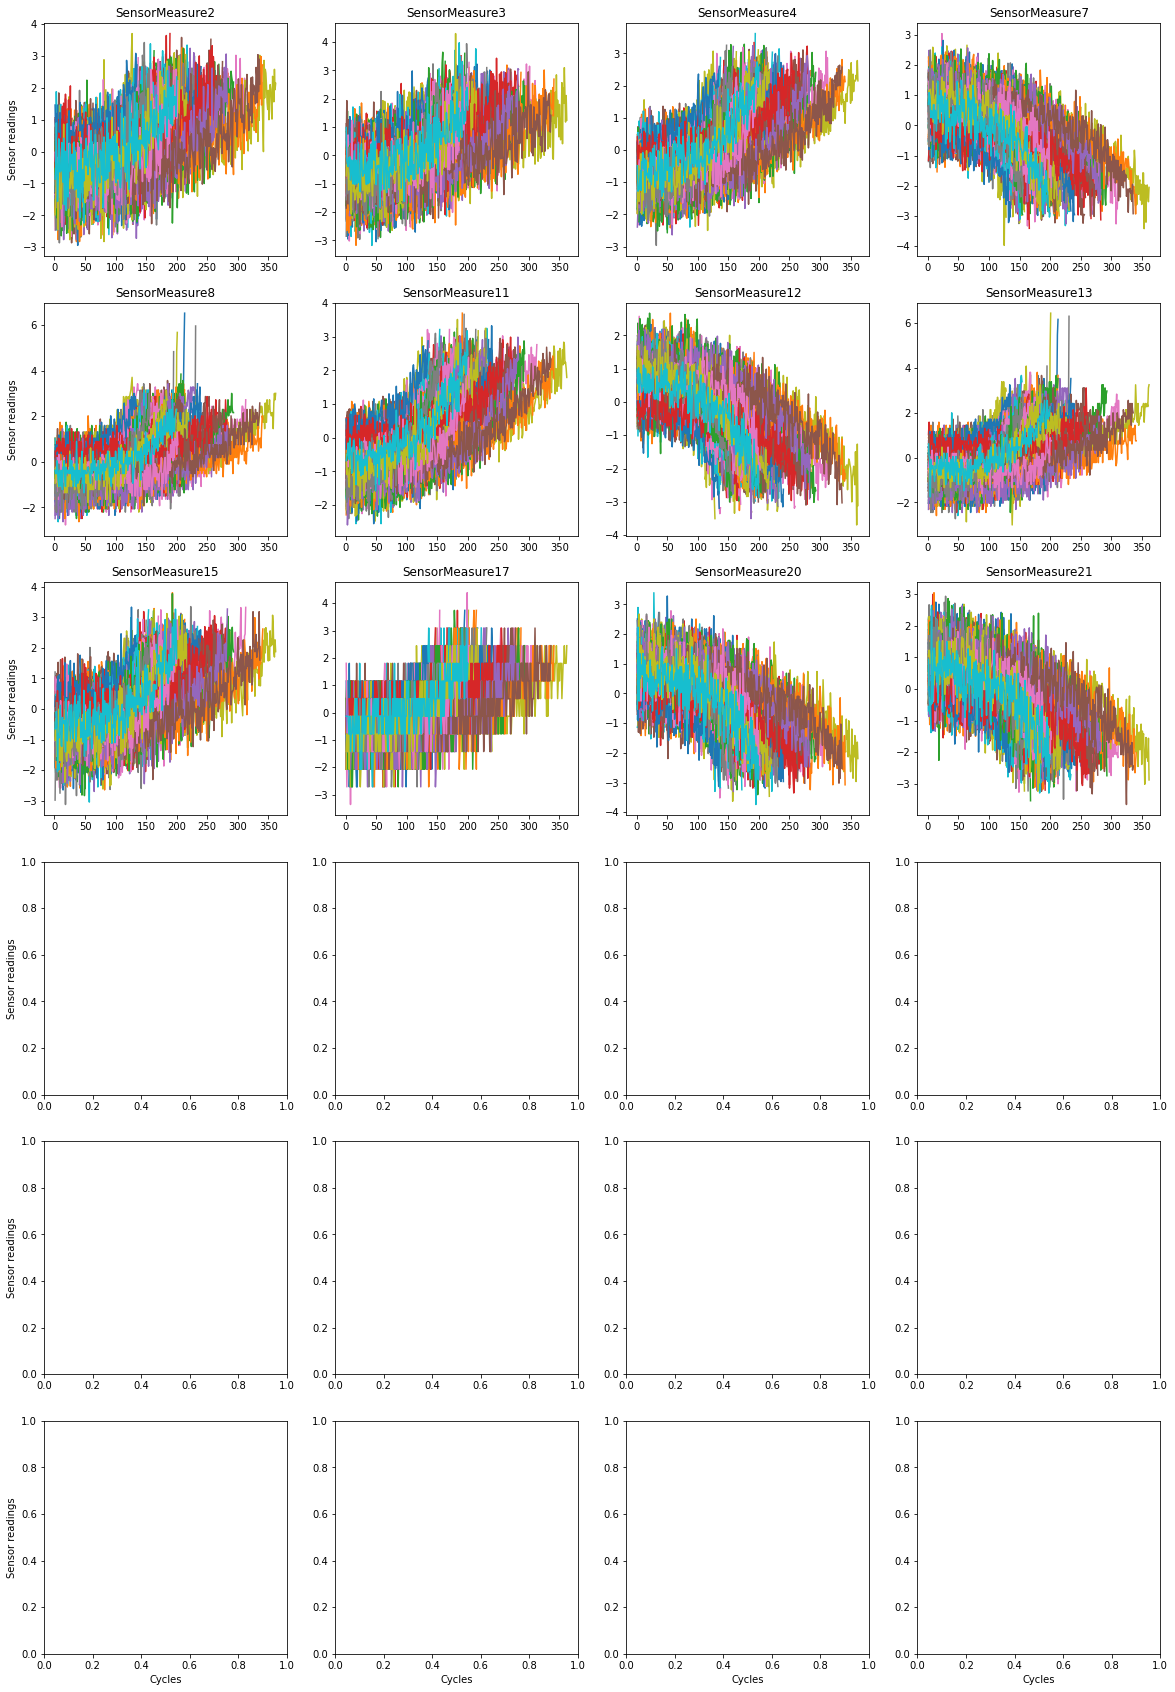

In [178]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
plot_by_engine(train_groupby, 6, ms_used, 'fd001-sensors_scaled.jpg')

In [179]:
train_data_df.to_csv('./fd001-scaled_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df[train_data_df.columns].to_csv('./fd001-scaled_test.csv', sep=' ', columns=train_data_df.columns, index=False)

### Smoothing curves

In [180]:
train_groupby = train_groupby[['ID', 'Cycle'] + ms_used]
test_groupby = test_groupby[['ID', 'Cycle'] + ms_used]
train_groupby.get_group(1)

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0     1      1       -1.721725       -0.134255       -0.925936   
1     1      2       -1.061780        0.211528       -0.643726   
2     1      3       -0.661813       -0.413166       -0.525953   
3     1      4       -0.661813       -1.261314       -0.784831   
4     1      5       -0.621816       -1.251528       -0.301518   
..   ..    ...             ...             ...             ...   
187   1    188        2.137957        1.933923        1.538403   
188   1    189        2.997886        0.921037        2.119489   
189   1    190        1.917975        1.418509        1.890610   
190   1    191        1.318024        1.930661        1.870611   
191   1    192        1.717992        1.775710        2.029493   

     SensorMeasure7  SensorMeasure8  SensorMeasure11  SensorMeasure12  \
0          1.121141       -0.516338        -0.266467         0.334262   
1          0.431930       -0.798093        -0.191583         1.174899   
2          1.008155       -0.234584        -1.015303         1.364721   
3          1.222827        0.188048        -1.539489         1.961302   
4          0.714393       -0.516338        -0.977861         1.052871   
..              ...             ...              ...              ...   
187       -1.613104        3.005594         1.717951        -2.201209   
188       -3.014122        2.442085         2.017485        -2.485941   
189       -2.347508        2.723839         2.953531        -1.862243   
190       -2.765554        2.582962         2.279578        -2.499500   
191       -2.392703        3.146471         2.653997        -1.808008   

     SensorMeasure13  SensorMeasure15  SensorMeasure17  SensorMeasure20  \
0          -1.058890        -0.603816        -0.781710         1.348493   
1          -0.363646        -0.275852        -0.781710         1.016528   
2          -0.919841        -0.649144        -2.073094         0.739891   
3          -0.224597        -1.971665        -0.781710         0.352598   
4          -0.780793        -0.339845        -0.136018         0.463253   
..               ...              ...              ...              ...   
187         1.861136         2.094554         1.801059        -1.694518   
188         3.251624         2.030561         1.155367        -1.860500   
189         3.529722         2.137216         3.092444        -1.805173   
190         2.834478         2.006564         0.509675        -2.026483   
191         3.112575         1.843915         1.801059        -1.860500   

     SensorMeasure21  
0           1.194427  
1           1.236922  
2           0.503423  
3           0.777792  
4           1.059552  
..               ...  
187        -3.056912  
188        -1.635180  
189        -2.052739  
190        -1.479981  
191        -3.000560  

[192 rows x 14 columns]

In [181]:
smoothing_columns = ['ID', 'Cycle'] + ms_used
train_groupby_arr = []
for i in range(len(train_groupby)):
    df = train_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.25)[:, 1], index=df.index, columns=[sn])
    train_groupby_arr.append(lowess_df)

tr_joined_lowess_df = train_groupby_arr[0]
for i in range(1, len(train_groupby_arr)):
    tr_joined_lowess_df = pd.concat([tr_joined_lowess_df, train_groupby_arr[i]])

test_groupby_arr = []
for i in range(len(test_groupby)):
    df = test_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.25)[:, 1], index=df.index, columns=[sn])
    test_groupby_arr.append(lowess_df)

test_joined_lowess_df = test_groupby_arr[0]
for i in range(1, len(test_groupby_arr)):
    test_joined_lowess_df = pd.concat([test_joined_lowess_df, test_groupby_arr[i]])

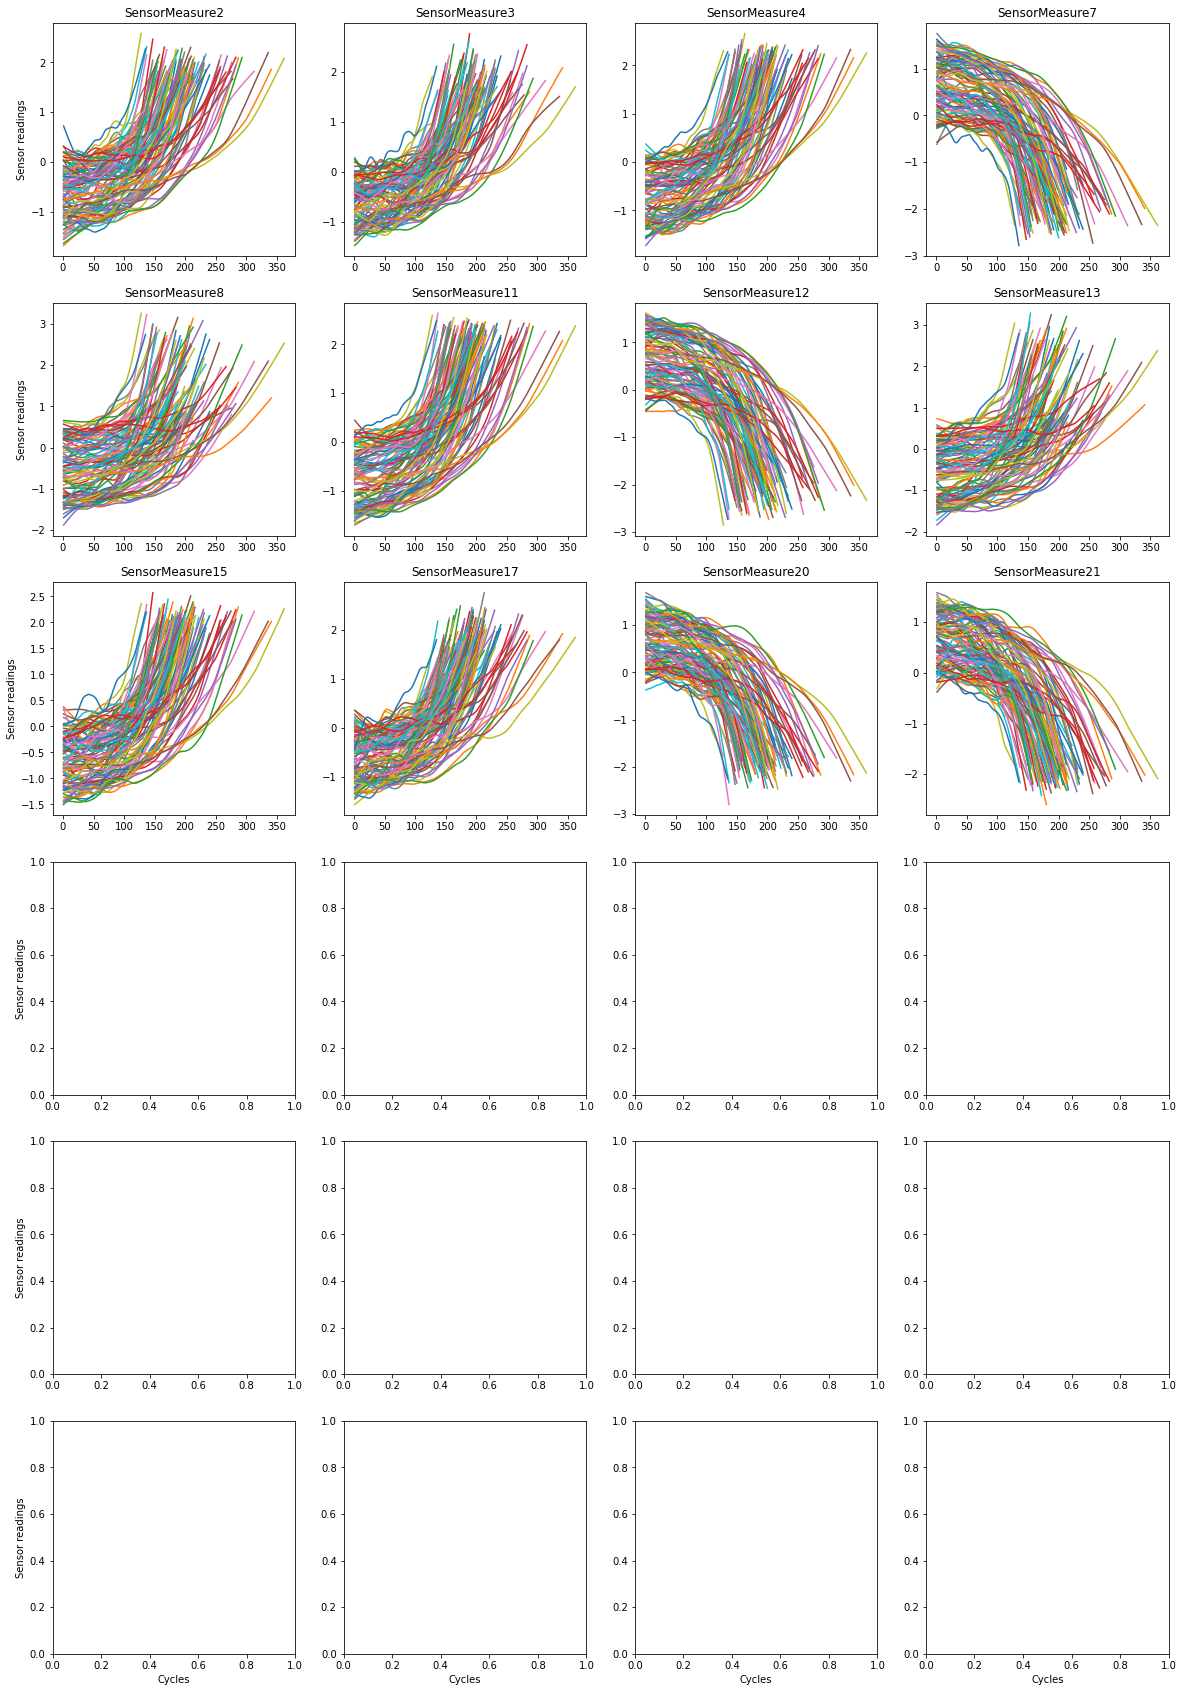

In [182]:
tr_joined_lowess_groupby = tr_joined_lowess_df.groupby(['ID'], sort = False)
plot_by_engine(tr_joined_lowess_groupby, 6, ms_used, 'fd001-sensors_smoothed.jpg')

In [183]:
tr_joined_lowess_df.to_csv('./fd001-smoothed_train.csv', sep=' ', columns=tr_joined_lowess_df.columns, index=False)
test_joined_lowess_df.to_csv('./fd001-smoothed_test.csv', sep=' ', columns=test_joined_lowess_df.columns, index=False)